<a href="https://colab.research.google.com/github/ziwei-z/w241-final-project/blob/main/Sentinel_1_and_2_Data_Prep_Ingestion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading Packages and docking drive

In [ ]:
#%%capture
!apt-get update
# Install GDAL and Geopandas
!apt-get install libgdal-dev 
!apt install gdal-bin python-gdal python3-gdal --quiet
!apt install python3-rtree --quiet
!pip install git+git://github.com/geopandas/geopandas.git --quiet

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [76.8 kB]
Hit:12 http://ppa.launchpad.net/cran/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# One may also need to add a shortcut to the shared drive like in 
# https://stackoverflow.com/questions/54351852/accessing-shared-with-me-with-colab/54352105#54352105

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd

import os
import re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from google.colab import files

## Pull in and stage cell_id data to match the MODIS logic 
From SnowCast Showdown Data Wrangling.ipynb

In [ ]:
gridcells = gpd.read_file('/content/drive/MyDrive/snowcapstone team spring 2022/Competition_Data/grid_cells.geojson')
print(gridcells.head())

                                cell_id           region  \
0  0003f387-71c4-48f6-b2b0-d853bd4f0aba          sierras   
1  000617d8-8c14-43e2-b708-7e3a69fe3cc3  central rockies   
2  000863e7-21e6-477d-b799-f5675c348627            other   
3  000ba8d9-d6d5-48da-84a2-1fa54951fae1          sierras   
4  00146204-d4e9-4cd8-8f86-d1ef133c5b6d          sierras   

                                            geometry  
0  POLYGON ((-118.71895 37.07419, -118.71895 37.0...  
1  POLYGON ((-107.07679 37.78042, -107.07679 37.7...  
2  POLYGON ((-119.40167 37.02400, -119.40167 37.0...  
3  POLYGON ((-119.32082 37.43171, -119.32082 37.4...  
4  POLYGON ((-118.52132 36.65735, -118.52132 36.6...  


In [ ]:
import json 

# with open('/content/drive/MyDrive/snowcapstone team spring 2022/Competition_Data/grid_cells.geojson') as f:
#    data = json.load(f)
# redundant to cell above

In [ ]:
traindf = pd.read_csv("/content/drive/MyDrive/snowcapstone team spring 2022/Competition_Data/train_labels.csv")

traindf = traindf.melt(id_vars=["cell_id"]).dropna().reset_index(drop = True)
traindf.rename(columns = {"cell_id":"cell_id", "variable":"date", "value":"SWE"}, inplace = True)

traindf = traindf.merge(gridcells, how = 'left', on='cell_id')


traindf = gpd.GeoDataFrame(traindf, crs ="EPSG:4326")
traindf.head()

,cell_id,date,SWE,region,geometry
0,00c4db22-a423-41a4-ada6-a8b1b04153a4,2013-01-01,12.7,other,"POLYGON ((-121.93492 41.16327, -121.93492 41.1..."
1,018cf1a1-f945-4097-9c47-0c4690538bb5,2013-01-01,20.4,sierras,"POLYGON ((-120.61440 39.67242, -120.61440 39.6..."
2,01be2cc7-ef77-4e4d-80ed-c4f8139162c3,2013-01-01,37.0,sierras,"POLYGON ((-119.60829 38.27575, -119.60829 38.2..."
3,02c3ec4a-8de4-4284-9ec1-5a942d3d098e,2013-01-01,2.3,other,"POLYGON ((-107.19357 44.57879, -107.19357 44.5..."
4,02cf33c2-c8e2-48b9-bf72-92506e97e251,2013-01-01,8.0,central rockies,"POLYGON ((-106.60068 40.39461, -106.60068 40.4..."


In [ ]:
from datetime import datetime, timedelta
traindf = traindf.loc[pd.to_datetime(traindf.date) >= datetime.strptime("2016-01-01", "%Y-%m-%d")].reset_index(drop = True)

In [ ]:
traindf.head()

,cell_id,date,SWE,region,geometry
0,00c4db22-a423-41a4-ada6-a8b1b04153a4,2016-01-05,10.6,other,"POLYGON ((-121.93492 41.16327, -121.93492 41.1..."
1,018cf1a1-f945-4097-9c47-0c4690538bb5,2016-01-05,16.4,sierras,"POLYGON ((-120.61440 39.67242, -120.61440 39.6..."
2,01be2cc7-ef77-4e4d-80ed-c4f8139162c3,2016-01-05,21.1,sierras,"POLYGON ((-119.60829 38.27575, -119.60829 38.2..."
3,02c3ec4a-8de4-4284-9ec1-5a942d3d098e,2016-01-05,2.0,other,"POLYGON ((-107.19357 44.57879, -107.19357 44.5..."
4,02cf33c2-c8e2-48b9-bf72-92506e97e251,2016-01-05,9.2,central rockies,"POLYGON ((-106.60068 40.39461, -106.60068 40.4..."


In [ ]:
traindf

,cell_id,date,SWE,region,geometry
0,00c4db22-a423-41a4-ada6-a8b1b04153a4,2016-01-05,10.6,other,"POLYGON ((-121.93492 41.16327, -121.93492 41.1..."
1,018cf1a1-f945-4097-9c47-0c4690538bb5,2016-01-05,16.4,sierras,"POLYGON ((-120.61440 39.67242, -120.61440 39.6..."
2,01be2cc7-ef77-4e4d-80ed-c4f8139162c3,2016-01-05,21.1,sierras,"POLYGON ((-119.60829 38.27575, -119.60829 38.2..."
3,02c3ec4a-8de4-4284-9ec1-5a942d3d098e,2016-01-05,2.0,other,"POLYGON ((-107.19357 44.57879, -107.19357 44.5..."
4,02cf33c2-c8e2-48b9-bf72-92506e97e251,2016-01-05,9.2,central rockies,"POLYGON ((-106.60068 40.39461, -106.60068 40.4..."
...,...,...,...,...,...
68665,fd4492f2-8aa9-4279-bdc0-73991786943f,2019-12-31,1.3,central rockies,"POLYGON ((-105.07354 38.87270, -105.07354 38.8..."
68666,fde3221a-9ce3-45a9-857f-bd196b07aa05,2019-12-31,5.6,central rockies,"POLYGON ((-106.10661 39.29804, -106.10661 39.3..."
68667,fdeb8912-f9d1-445d-aadb-e943534f67fe,2019-12-31,8.8,central rockies,"POLYGON ((-107.92120 37.79462, -107.92120 37.8..."
68668,fe33672e-7ea7-4c5d-8639-96b2cc7edb0c,2019-12-31,2.9,other,"POLYGON ((-122.02475 43.89659, -122.02475 43.9..."


In [ ]:
traindf= traindf[traindf['region']== 'sierras']

In [ ]:
traindf = traindf.reset_index(drop=True)
traindf

,cell_id,date,SWE,region,geometry
0,018cf1a1-f945-4097-9c47-0c4690538bb5,2016-01-05,16.4,sierras,"POLYGON ((-120.61440 39.67242, -120.61440 39.6..."
1,01be2cc7-ef77-4e4d-80ed-c4f8139162c3,2016-01-05,21.1,sierras,"POLYGON ((-119.60829 38.27575, -119.60829 38.2..."
2,04b7603c-26c6-4004-a8bc-58b2b60e810e,2016-01-05,3.5,sierras,"POLYGON ((-118.34166 36.56361, -118.34166 36.5..."
3,147d5eb4-e574-47e4-994a-8a2908c06050,2016-01-05,11.7,sierras,"POLYGON ((-120.87491 39.78297, -120.87491 39.7..."
4,174e3100-c30e-46a4-ac7c-30cd521fc390,2016-01-05,12.9,sierras,"POLYGON ((-119.54540 37.63117, -119.54540 37.6..."
...,...,...,...,...,...
32159,962f6718-ce02-4d13-b28c-e159d1adc2d4,2019-12-31,17.7,sierras,"POLYGON ((-119.79693 38.48700, -119.79693 38.4..."
32160,a4e8e597-1c21-4a46-bf08-2ee5149c481c,2019-12-31,11.3,sierras,"POLYGON ((-118.56624 36.92353, -118.56624 36.9..."
32161,d37da01c-d9d7-4cbf-985a-af44d5a3e1e9,2019-12-31,7.2,sierras,"POLYGON ((-119.86880 38.02850, -119.86880 38.0..."
32162,d674ee8e-49f1-44c9-890d-4e04997522a1,2019-12-31,7.4,sierras,"POLYGON ((-119.91371 38.92164, -119.91371 38.9..."


In [ ]:
import shutil
import os
import requests
import ee
from datetime import datetime, timedelta

traindf["date"] = pd.to_datetime(traindf.date)


#I am creating a string version of the date to use as a filename
traindf["datestring"] = traindf.date.map(lambda d: str(d.year)+d.strftime('%j'))

#Now I calculate my centroid from the provided geometry
#Ignore the warnings this creates. It is in a projected crs
traindf["centroid"] = traindf.geometry.to_crs('EPSG:32631').centroid
traindf["center_lat"] = traindf.centroid.y
traindf["center_long"] = traindf.centroid.x

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



In [ ]:
traindf

,cell_id,date,SWE,region,geometry,datestring,centroid,center_lat,center_long
0,018cf1a1-f945-4097-9c47-0c4690538bb5,2016-01-05,16.4,sierras,"POLYGON ((-120.61440 39.67242, -120.61440 39.6...",2016005,POINT (-4350252.837 13751971.654),39.675880,-120.618890
1,01be2cc7-ef77-4e4d-80ed-c4f8139162c3,2016-01-05,21.1,sierras,"POLYGON ((-119.60829 38.27575, -119.60829 38.2...",2016005,POINT (-4574780.281 13818928.867),38.279274,-119.612777
2,04b7603c-26c6-4004-a8bc-58b2b60e810e,2016-01-05,3.5,sierras,"POLYGON ((-118.34166 36.56361, -118.34166 36.5...",2016005,POINT (-4862886.063 13896838.165),36.567220,-118.346152
3,147d5eb4-e574-47e4-994a-8a2908c06050,2016-01-05,11.7,sierras,"POLYGON ((-120.87491 39.78297, -120.87491 39.7...",2016005,POINT (-4318250.990 13760557.964),39.786417,-120.879401
4,174e3100-c30e-46a4-ac7c-30cd521fc390,2016-01-05,12.9,sierras,"POLYGON ((-119.54540 37.63117, -119.54540 37.6...",2016005,POINT (-4646566.370 13882630.253),37.634731,-119.549895
...,...,...,...,...,...,...,...,...,...
32159,962f6718-ce02-4d13-b28c-e159d1adc2d4,2019-12-31,17.7,sierras,"POLYGON ((-119.79693 38.48700, -119.79693 38.4...",2019365,POINT (-4537332.186 13811806.858),38.490519,-119.801423
32160,a4e8e597-1c21-4a46-bf08-2ee5149c481c,2019-12-31,11.3,sierras,"POLYGON ((-118.56624 36.92353, -118.56624 36.9...",2019365,POINT (-4804969.773 13877045.665),36.927121,-118.570731
32161,d37da01c-d9d7-4cbf-985a-af44d5a3e1e9,2019-12-31,7.2,sierras,"POLYGON ((-119.86880 38.02850, -119.86880 38.0...",2019365,POINT (-4578251.610 13866381.744),38.032042,-119.873288
32162,d674ee8e-49f1-44c9-890d-4e04997522a1,2019-12-31,7.4,sierras,"POLYGON ((-119.91371 38.92164, -119.91371 38.9...",2019365,POINT (-4483195.051 13775359.274),38.925134,-119.918204


## Sentinel 1 Main Function



In [ ]:

def pull_Sentinel(traindf, overwrite = False, names_only = False ):
  ##Main loop that iterates over areas and stores images in file
  ##For test image of one AOI see below
  filelocations = []
  x= 0


  for i in range(len(traindf.SWE)):
    #create a name for the image
    pict_name = traindf.cell_id[i] + '_sentinel1_poly' + traindf.datestring[i] + '.jpg'

    #create the whole filename with path to the correct folder
    filename = os.path.join('/content/drive/MyDrive/snowcapstone team spring 2022/Sen1_Data_poly', pict_name)

    if names_only:
      filelocations.append(filename)
      x += 1
      if x % 5000 == 0:
        print(f'{x} files already exist')

    elif os.path.exists(filename) and not overwrite:
      filelocations.append(filename)
      x += 1
      if x % 5000 == 0:
        print(f'{x} files already exist')

    else:

      #define area of interest by coordinates
      aoi = ee.Geometry.Polygon(list(traindf.geometry[0].exterior.coords))
      #print(aoi)
      start_date = traindf.date[i] - timedelta(days = 80)
      end_date = traindf.date[i] + timedelta(days = 1)

      year = start_date.year
      #print(year)

      if year >=2016:
        x+=1
        try:
          #print("calculating")
          # Sentinel-1 image filtered on date range and on aoi
          se2 = ee.ImageCollection('COPERNICUS/S1_GRD')\
          .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
          .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))\
          .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV').Not())\
          .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH').Not())\
          .filterDate(start_date, end_date)\
          .filterBounds(aoi)\
          .sort('system:time_start', False)\
          .first()

          #Create a ratio band of VV/VH

          VVVH = (se2.select('VV').divide(se2.select('VH')))

          se2 = se2.addBands(VVVH.rename('VVVH'))

          rgb = ['VV', 'VH', 'VVVH']


          url = se2.select(rgb).clip(aoi).getThumbURL({'min': -50, 'max': 1, 'region': aoi, 'format': 'jpg'})

          #add the name to my list I created earlier
          filelocations.append(filename)

          #now I open the url and download the image to the specified file location
          response = requests.get(url, stream=True)
          with open(filename, 'wb') as out_file:
            shutil.copyfileobj(response.raw, out_file)
          del response
        
        except Exception as e:
          filelocations.append("NULL")
        
      else:
        x+=1
        #print("skip")
        filelocations.append("NULL")

      if x % 5000 == 0:
        print(x, "files complete")

  traindf['sentinel1a_filelocation'] = filelocations

###Sentinel 1 Call

When both sentinel satellites are working you get a 6 day repeat. With one down it is a 12 day.

This calls a really long time range of 80 days, but selects the most proximal to the date of the SWE and returns the image for that only. 

In [ ]:
##Test statement for ee API
try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

pull_Sentinel(traindf)



To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=YHtiwDMjaLS6-9mzykU5HgR_I71Ig76264oGmdhvnp0&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWjQek1I3PLpqs60cDafaAkzbhM7ujdRyK2RQJL6gF6u4HvWBLckA78

Successfully saved authorization token.
5000 files complete
10000 files already exist
15000 files already exist
20000 files complete
25000 files complete
30000 files complete


In [ ]:
#Check to confirm file locations were written to dataframe
traindf

,cell_id,date,SWE,region,geometry,datestring,centroid,center_lat,center_long,sentinel1a_filelocation
0,018cf1a1-f945-4097-9c47-0c4690538bb5,2016-01-05,16.4,sierras,"POLYGON ((-120.61440 39.67242, -120.61440 39.6...",2016005,POINT (-4350252.837 13751971.654),39.675880,-120.618890,NULL
1,01be2cc7-ef77-4e4d-80ed-c4f8139162c3,2016-01-05,21.1,sierras,"POLYGON ((-119.60829 38.27575, -119.60829 38.2...",2016005,POINT (-4574780.281 13818928.867),38.279274,-119.612777,NULL
2,04b7603c-26c6-4004-a8bc-58b2b60e810e,2016-01-05,3.5,sierras,"POLYGON ((-118.34166 36.56361, -118.34166 36.5...",2016005,POINT (-4862886.063 13896838.165),36.567220,-118.346152,NULL
3,147d5eb4-e574-47e4-994a-8a2908c06050,2016-01-05,11.7,sierras,"POLYGON ((-120.87491 39.78297, -120.87491 39.7...",2016005,POINT (-4318250.990 13760557.964),39.786417,-120.879401,NULL
4,174e3100-c30e-46a4-ac7c-30cd521fc390,2016-01-05,12.9,sierras,"POLYGON ((-119.54540 37.63117, -119.54540 37.6...",2016005,POINT (-4646566.370 13882630.253),37.634731,-119.549895,NULL
...,...,...,...,...,...,...,...,...,...,...
32159,962f6718-ce02-4d13-b28c-e159d1adc2d4,2019-12-31,17.7,sierras,"POLYGON ((-119.79693 38.48700, -119.79693 38.4...",2019365,POINT (-4537332.186 13811806.858),38.490519,-119.801423,/content/drive/MyDrive/snowcapstone team sprin...
32160,a4e8e597-1c21-4a46-bf08-2ee5149c481c,2019-12-31,11.3,sierras,"POLYGON ((-118.56624 36.92353, -118.56624 36.9...",2019365,POINT (-4804969.773 13877045.665),36.927121,-118.570731,/content/drive/MyDrive/snowcapstone team sprin...
32161,d37da01c-d9d7-4cbf-985a-af44d5a3e1e9,2019-12-31,7.2,sierras,"POLYGON ((-119.86880 38.02850, -119.86880 38.0...",2019365,POINT (-4578251.610 13866381.744),38.032042,-119.873288,/content/drive/MyDrive/snowcapstone team sprin...
32162,d674ee8e-49f1-44c9-890d-4e04997522a1,2019-12-31,7.4,sierras,"POLYGON ((-119.91371 38.92164, -119.91371 38.9...",2019365,POINT (-4483195.051 13775359.274),38.925134,-119.918204,/content/drive/MyDrive/snowcapstone team sprin...


#Sentinel 2 Function Bands B8A, B11, B12

In [ ]:
def pull_Sentinel2a(traindf, overwrite = False, names_only = False ):
  ##Main loop that iterates over areas and stores images in file
  ##For test image of one AOI see below
  filelocations = []
  x= 0


  for i in range(len(traindf.SWE)):
    #create a name for the image
    pict_name = traindf.cell_id[i] + '_sentinel2a_poly' + traindf.datestring[i] + '.jpg'

    #create the whole filename with path to the correct folder
    filename = os.path.join('/content/drive/MyDrive/snowcapstone team spring 2022/Sen2_DataA_poly', pict_name)

    if names_only:
      filelocations.append(filename)
      x += 1
      if x % 5000 == 0:
        print(f'{x} files already exist')

    elif os.path.exists(filename) and not overwrite:
      filelocations.append(filename)
      x += 1
      if x % 5000 == 0:
        print(f'{x} files already exist')

    else:

      #define area of interest by coordinates
      aoi = ee.Geometry.Polygon(list(traindf.geometry[0].exterior.coords))
      #print(aoi)
      start_date = traindf.date[i] - timedelta(days = 80)
      end_date = traindf.date[i] + timedelta(days = 1)

      year = start_date.year
      #print(year)

      if year >=2016:
        x+=1
        try:
          #print("calculating")
          # Sentinel-1 image filtered on date range and on aoi
          se2 = ee.ImageCollection('COPERNICUS/S2')\
            .filter(ee.Filter.date(ee.Date('2020-01-01'), ee.Date('2021-01-01')))\
            .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', 10))\
            .filterBounds(aoi) \
            .select(['B8A', 'B11', 'B12'])\
            .sort('system:time_start', False)\
            .first()

          #Create a ratio band of (B8a-B11)/(B8a+B11)

          BRatio = se2.expression(
              '(B8 - B11)/(B8 + B11)', {
                  'B8': se2.select('B8A'),
                  'B11': se2.select('B11')
              })

          se2 = se2.addBands(BRatio.rename('BRatio'))


          rgb = ['BRatio', 'B11', 'B12']


          url = se2.select(rgb).clip(aoi).getThumbURL({'min': 0, 'max':10000, 'region': aoi, 'format': 'jpg'})

          #add the name to my list I created earlier
          filelocations.append(filename)

          #now I open the url and download the image to the specified file location
          response = requests.get(url, stream=True)
          with open(filename, 'wb') as out_file:
            shutil.copyfileobj(response.raw, out_file)
          del response
        
        except Exception as e:
          filelocations.append("NULL")
        
      else:
        x+=1
        #print("skip")
        filelocations.append("NULL")

      if x % 5000 == 0:
        print(x, "files complete")

  traindf['sentinel2a_filelocation'] = filelocations

#Sentinel 2 Function Bands B8 B4 B2

In [ ]:
def pull_Sentinel2b(traindf, overwrite = False, names_only = False ):
  ##Main loop that iterates over areas and stores images in file
  ##For test image of one AOI see below
  filelocations = []
  x= 0


  for i in range(len(traindf.SWE)):
    #create a name for the image
    pict_name = traindf.cell_id[i] + '_sentinel2b_poly' + traindf.datestring[i] + '.jpg'

    #create the whole filename with path to the correct folder
    filename = os.path.join('/content/drive/MyDrive/snowcapstone team spring 2022/Sen2_DataB_poly', pict_name)

    if names_only:
      filelocations.append(filename)
      x += 1
      if x % 5000 == 0:
        print(f'{x} files already exist')

    elif os.path.exists(filename) and not overwrite:
      filelocations.append(filename)
      x += 1
      if x % 5000 == 0:
        print(f'{x} files already exist')

    else:

      #define area of interest by coordinates
      aoi = ee.Geometry.Polygon(list(traindf.geometry[0].exterior.coords))
      #print(aoi)
      start_date = traindf.date[i] - timedelta(days = 80)
      end_date = traindf.date[i] + timedelta(days = 1)

      year = start_date.year
      #print(year)

      if year >=2016:
        x+=1
        try:
          #print("calculating")
          # Sentinel-1 image filtered on date range and on aoi
          se2 = ee.ImageCollection('COPERNICUS/S2')\
            .filter(ee.Filter.date(ee.Date('2020-01-01'), ee.Date('2021-01-01')))\
            .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', 10))\
            .filterBounds(aoi) \
            .select(['B8', 'B4', 'B2'])\
            .sort('system:time_start', False)\
            .first()

          #Create a ratio band of (B8a-B11)/(B8a+B11)

          BRatio = se2.expression(
              '(B8 - B4)/(B8 + B4)', {
                  'B8': se2.select('B8'),
                  'B4': se2.select('B4')
              })

          se2 = se2.addBands(BRatio.rename('BRatio'))


          rgb = ['BRatio', 'B2', 'B4']


          url = se2.select(rgb).clip(aoi).getThumbURL({'min': 0, 'max':10000, 'region': aoi, 'format': 'jpg'})

          #add the name to my list I created earlier
          filelocations.append(filename)

          #now I open the url and download the image to the specified file location
          response = requests.get(url, stream=True)
          with open(filename, 'wb') as out_file:
            shutil.copyfileobj(response.raw, out_file)
          del response
        
        except Exception as e:
          filelocations.append("NULL")
        
      else:
        x+=1
        #print("skip")
        filelocations.append("NULL")

      if x % 5000 == 0:
        print(x, "files complete")

  traindf['sentinel2b_filelocation'] = filelocations

In [ ]:
#Write to csv 
traindf.to_csv('/content/drive/MyDrive/snowcapstone team spring 2022/SENTINEL1_FileLocations.csv', index=False)

### Sentinel 1 Optimization SandBox

In [ ]:

import shapely.geometry

area_of_interest = traindf['geometry'][0]
shapely_polygon = shapely.geometry.Polygon(area_of_interest)
item = gpd.GeoSeries([shapely_polygon]).to_json()

item

'{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [[[-121.9349218899677, 41.163266139578], [-121.9349218899677, 41.17002864097398], [-121.9439050428089, 41.17002864097398], [-121.9439050428089, 41.163266139578], [-121.9349218899677, 41.163266139578]]]}, "bbox": [-121.9439050428089, 41.163266139578, -121.9349218899677, 41.17002864097398]}], "bbox": [-121.9439050428089, 41.163266139578, -121.9349218899677, 41.17002864097398]}'

In [ ]:
print(list(traindf.geometry[0].exterior.coords))

[(-121.9349218899677, 41.163266139578), (-121.9349218899677, 41.17002864097398), (-121.9439050428089, 41.17002864097398), (-121.9439050428089, 41.163266139578), (-121.9349218899677, 41.163266139578)]


In [ ]:
pict_name = traindf.cell_id[0] + '_TESTSen2_' + traindf.datestring[0] + '.jpg'


#create the whole filename with path to the correct folder
filename = os.path.join('/content/drive/MyDrive/snowcapstone team spring 2022/Sen_TEST', pict_name)


#define area of interest by coordinates
aoi = ee.Geometry.Polygon(list(traindf.geometry[0].exterior.coords))
      #print(aoi)
start_date = traindf.date[0] - timedelta(days = 800)
end_date = traindf.date[0] + timedelta(days = 1)

# Sentinel-1 image filtered on date range and on aoi
se2 = ee.ImageCollection('COPERNICUS/S2')\
.filter(ee.Filter.date(ee.Date('2020-01-01'), ee.Date('2021-01-01')))\
.filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', 10))\
.filterBounds(aoi) \
.select(['B8A', 'B11', 'B12'])\
.sort('system:time_start', False)\
.first()

BRatio = se2.expression(
  '(B8 - B11)/(B8 + B11)', {
  'B8': se2.select('B8A'),
  'B11': se2.select('B11')
  })

se2 = se2.addBands(BRatio.rename('BRatio'))

rgb = ['BRatio', 'B11', 'B12']

date = ee.Date(se2.get('system:time_start')).format("yyyy-MM-dd")
print(date.getInfo())
url = se2.select(rgb).clip(aoi).getThumbURL({'min': 0, 'max':10000, 'region': aoi, 'format': 'jpg'})


#now I open the url and download the image to the specified file location
response = requests.get(url, stream=True)
with open(filename, 'wb') as out_file:
  shutil.copyfileobj(response.raw, out_file)
del response
        



2020-12-30


(39, 39, 3)
The image consists of 1521 pixels


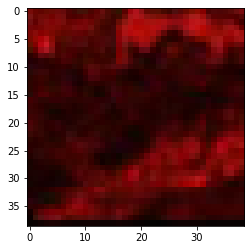

In [ ]:
### Check out image
test1=plt.imread('/content/drive/MyDrive/snowcapstone team spring 2022/Sen_TEST/00c4db22-a423-41a4-ada6-a8b1b04153a4_TESTSen2_2016005.jpg')
print(test1.shape)
print(f"The image consists of {test1.shape[0] * test1.shape[1]} pixels")
plt.imshow(test1);

In [ ]:
test1

array([[[ 13,   0,  21],
        [ 12,   0,  26],
        [  3,   0,  23],
        ...,
        [188, 183, 241],
        [191, 186, 226],
        [  1,   0,  15]],

       [[209, 181, 222],
        [195, 177, 215],
        [199, 189, 226],
        ...,
        [195, 173, 237],
        [197, 180, 225],
        [  6,   0,  16]],

       [[197, 173, 221],
        [191, 174, 219],
        [202, 190, 236],
        ...,
        [200, 165, 233],
        [202, 174, 225],
        [  8,   0,  19]],

       ...,

       [[  1,   0,  18],
        [192, 176, 215],
        [203, 173, 235],
        ...,
        [194, 163, 243],
        [189, 154, 238],
        [188, 148, 236]],

       [[  2,   0,  20],
        [194, 176, 218],
        [201, 171, 235],
        ...,
        [194, 170, 228],
        [190, 164, 225],
        [189, 160, 226]],

       [[  4,   0,  21],
        [194, 172, 218],
        [198, 166, 231],
        ...,
        [  3,   0,  12],
        [  3,   0,  14],
        [  4,   0,  18]]

## Sentinel 2 ingestion

### Google Earth Engine version (not permissible for competition)

In [ ]:

def pull_Sentinel(traindf, overwrite = False, names_only = False ):
  ##Main loop that iterates over areas and stores images in file
  ##For test image of one AOI see below
  filelocations = []
  x= 0
  proj = ee.Projection('EPSG:32631')

  for i in range(len(traindf.SWE)):
    #create a name for the image
    pict_name = traindf.cell_id[i] + '_sentinel2_' + traindf.datestring[i] + '.jpg'

    #create the whole filename with path to the correct folder
    filename = os.path.join('/content/drive/MyDrive/snowcapstone team spring 2022/Sen2_Data',pict_name)

    if names_only:
      filelocations.append(filename)
      x += 1
      if x % 5000 == 0:
        print(f'{x} files already exist')

    elif os.path.exists(filename) and not overwrite:
      filelocations.append(filename)
      x += 1
      if x % 5000 == 0:
        print(f'{x} files already exist')

    else:

       #define area of interest by coordinates
      aoi = ee.Geometry.Point((traindf.center_long[i], traindf.center_lat[i]), proj = proj)
      #print(aoi)
      start_date = traindf.date[i] - timedelta(days = 90)
      end_date = traindf.date[i] + timedelta(days = 1)

      year = traindf.date[i].year
      #print(year)

          #umbImages = ee.ImageCollection('COPERNICUS/S2').filterDate(start_date, end_date).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)).filterBounds(aoi).size();
          #print('numbImages', numbImages)
      if year >=2016:
        x+=1
        #print("calculating")
        rgb = ['B2','B11','B12']
        # Sentinel-2 image filtered on date range and on aoi
        se2 = ee.ImageCollection('COPERNICUS/S2') \
                        .filter(ee.Filter.date(start_date, end_date)) \
                        .filter(ee.Filter.notNull(['system:index'])) \
                        .select(rgb) \
                        .sort('system:index', False) 


        #Because the image collection is limited to a single day, there is only one image
        #So I just take it
        point = se2.first().reproject(crs = 'EPSG:32631').clip(aoi.buffer(100))

        # Get individual band arrays and build them into an RGB image
        # The "buffer" is a circular distance around the point, measured in meters right now it is 100km
        #rgb = ee.Image.rgb(point.clip(aoi.buffer(1)).select(rgb[0]), #I divide by 100 to get it between 0 and 1
        #                  point.clip(aoi.buffer(1)).select(rgb[1]), #I divide by 100 to get it between 0 and 1
        #                  point.clip(aoi.buffer(1)).select(rgb[2])).visualize() #I divide by 10000 to get it between 0 and 1

        #Now I get the url for the image
        url = point.getThumbURL({'bands': rgb, 'min': 0, 'max': 2500, 'gamma': 1.1})

        #add the name to my list I created earlier
        filelocations.append(filename)

        #now I open the url and download the image to the specified file location
        response = requests.get(url, stream=True)
        with open(filename, 'wb') as out_file:
          shutil.copyfileobj(response.raw, out_file)
        del response
        
      else:
        x+=1
        #print("skip")
        filelocations.append("No Data")

      if x % 5000 == 0:
        print(x, "files complete")

  traindf['sentinel2_filelocation'] = filelocations

In [ ]:
import IPython.display as disp
filelocations = []
x= 0
proj = ee.Projection('EPSG:32631')
for i in range(400,401):
  #define area of interest by coordinates
  aoi = ee.Geometry.Point((traindf.center_long[i], traindf.center_lat[i]), proj = proj)
  #print(aoi)
  start_date = traindf.date[i] - timedelta(days = 90)
  end_date = traindf.date[i] + timedelta(days = 1)

  year = traindf.date[i].year
  #print(year)

      #umbImages = ee.ImageCollection('COPERNICUS/S2').filterDate(start_date, end_date).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)).filterBounds(aoi).size();
      #print('numbImages', numbImages)
  if year >=2016:
    x+=1
    #print("calculating")
    rgb = ['B2','B11','B12']
    # Sentinel-2 image filtered on date range and on aoi
    se2 = ee.ImageCollection('COPERNICUS/S2') \
                    .filter(ee.Filter.date(start_date, end_date)) \
                    .filter(ee.Filter.notNull(['system:index'])) \
                    .select(rgb) \
                    .sort('system:index', False) 


    #Because the image collection is limited to a single day, there is only one image
    #So I just take it
    point = se2.first().reproject(crs = 'EPSG:32631').clip(aoi.buffer(100))

    # Get individual band arrays and build them into an RGB image
    # The "buffer" is a circular distance around the point, measured in meters right now it is 100km
    #rgb = ee.Image.rgb(point.clip(aoi.buffer(1)).select(rgb[0]), #I divide by 100 to get it between 0 and 1
    #                  point.clip(aoi.buffer(1)).select(rgb[1]), #I divide by 100 to get it between 0 and 1
    #                  point.clip(aoi.buffer(1)).select(rgb[2])).visualize() #I divide by 10000 to get it between 0 and 1

    #Now I get the url for the image
    url = point.getThumbURL({'bands': rgb, 'min': 0, 'max': 2500, 'gamma': 1.1})

In [ ]:
url

'https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/56f86ae083344c000efe1f077c2710d2-d7b91fcdc9364c246382bedfbfe0c2f5:getPixels'

In [ ]:
##Test statement for ee API
try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

## Ingest data
#pull_Sentinel(traindf, overwrite = True, names_only= False)

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=z8BPPBXn6HREbIGtLnmrh3pGWZGk32SpzgqhrLE9ZuU&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWiTTSG4HFvLnulgWbzeWBZUv4YyZ_sgke5yMqz8QWmz9DLbLZq6d9Y

Successfully saved authorization token.


Possible better image save solution: https://geemap.org/notebooks/21_export_map_to_html_png/

(2, 2, 4)
The image consists of 4 pixels


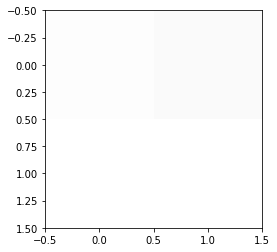

In [ ]:
test1=plt.imread('/content/drive/MyDrive/snowcapstone team spring 2022/Sen1_Data/2f5c1968-2c34-4539-a9f4-38298d0de925_sentinel1_VV_2016033.jpg')
print(test1.shape)
print(f"The image consists of {test1.shape[0] * test1.shape[1]} pixels")
plt.imshow(test1);

In [ ]:
test1

array([[[0, 0, 0, 2],
        [0, 0, 0, 5]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

In [ ]:
test2

array([[[3, 3, 3, 8]]], dtype=uint8)

(1, 1, 4)
The image consists of 1 pixels


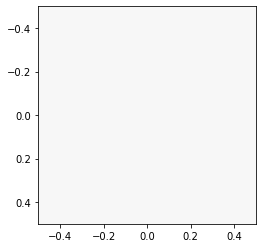

In [ ]:
test2=plt.imread('/content/drive/MyDrive/snowcapstone team spring 2022/Sen1_Data/2f266b81-aad3-4c26-ac69-1bd04a208bf7_sentinel1_VV_2016033.jpg')
print(test2.shape)
print(f"The image consists of {test2.shape[0] * test2.shape[1]} pixels")
plt.imshow(test2);


##Single trial example
### Sentinel 2 with cloud masking
https://developers.google.com/earth-engine/tutorials/community/sentinel-2-s2cloudless



In [ ]:
try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

# get a single polygon
aoi = ee.Geometry.Polygon(traindf.geometry[0])
print(aoi)
#print(aoi)

# Sentinel-2 image filtered on 2019 and on aoi
se2 = ee.ImageCollection('COPERNICUS/S2').filterDate("2019-01-01","2019-12-31").filterBounds(aoi).median().divide(10000)

rgb = ['B12','B11','B2']

# set some thresholds
rgbViz = {"min":0.0, "max":0.9,"bands":rgb}


# initialize our map
map1 = geemap.Map()
map1.centerObject(aoi, 7)
map1.addLayer(se2.clip(aoi), rgbViz, "S2")

map1.addLayerControl()
map1

TypeError: ignored

In [ ]:
##Cloud mask filster

def se2mask(image):
    quality_band = image.select('QA60')
    
    # using the bit mask for clouds and cirrus clouds respectively
    cloudmask = 1 << 10
    cirrusmask = 1 << 11
    
    # we only want clear skies
    mask = quality_band.bitwiseAnd(cloudmask).eq(0) and (quality_band.bitwiseAnd(cirrusmask).eq(0))
    
    # we'll divide by 10000 to make interpreting the reflectance values easier
    return image.updateMask(mask).divide(10000)
    
se2 = ee.ImageCollection('COPERNICUS/S2').filterDate(
    "2019-01-01","2019-12-31").filterBounds(aoi).filter(
    ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE",20)).map(se2mask).median()

# initialize our map
map2 = geemap.Map()
map2.centerObject(aoi, 7)
map2.addLayer(se2.clip(aoi), rgbViz, "S2")

map2.addLayerControl()
map2

Map(center=[37.07777579811751, -118.72344474923563], controls=(WidgetControl(options=['position', 'transparent…

In [ ]:
#se2.getInfo()

#url = se2.select(rgb).clip(aoi).getThumbURL({'min': -20, 'max': 0})

url

'https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/01c290075fbda695e0a58f1b8e9f3bc0-3bff08612d82e5765ab4f731dd2720d7:getPixels'

# Test Area

In [ ]:
pip install geemap

     |████████████████████████████████| 1.9 MB 27.3 MB/s 
     |████████████████████████████████| 5.4 MB 57.3 MB/s 
     |████████████████████████████████| 176 kB 70.8 MB/s 
     |████████████████████████████████| 98 kB 10.5 MB/s 
     |████████████████████████████████| 44 kB 3.2 MB/s 
     |████████████████████████████████| 1.3 MB 68.4 MB/s 
     |████████████████████████████████| 216 kB 71.2 MB/s 
     |████████████████████████████████| 95 kB 5.2 MB/s 
     |████████████████████████████████| 8.7 MB 70.3 MB/s 
     |████████████████████████████████| 130 kB 59.9 MB/s 
     |████████████████████████████████| 1.2 MB 59.5 MB/s 
     |████████████████████████████████| 1.7 MB 71.3 MB/s 
     |████████████████████████████████| 99 kB 11.6 MB/s 
     |████████████████████████████████| 3.3 MB 61.4 MB/s 
     |████████████████████████████████| 76 kB 7.3 MB/s 
     |████████████████████████████████| 97 kB 9.1 MB/s 
     |████████████████████████████████| 428 kB 62.0 MB/s 
     |██████████████████

## GEE UTILS

In [ ]:
pip install geeutils

In [ ]:
import ee
import geemap

try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()
        
import sys
sys.path.append('../src/geepatches')
import geeutils

ModuleNotFoundError: ignored

Testing with one 1k x 1k location in our region:

In [ ]:
aoi = ee.Geometry.Point((-121.939413466388, 41.1666473902759))
  #.buffer(100)

eeimagecollection = (ee.ImageCollection('COPERNICUS/S1_GRD')
                     .filter(ee.Filter.date(ee.Date('2020-01-01'), ee.Date('2021-01-01')))
                     .filterBounds(aoi.buffer(1000000)))


size_all     = (eeimagecollection.size().getInfo())
size_none    = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH').Not())
                .size().getInfo())
size_VV_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH').Not())
                .size().getInfo())
size_VH_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH').Not())
                .size().getInfo())
size_HV_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH').Not())
                .size().getInfo())
size_HH_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH'))
                .size().getInfo())
size_VVVH_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH').Not())
                .size().getInfo())
size_HVHH_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH'))
                .size().getInfo())
size_VVVHHVHH_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH'))
                .size().getInfo())
                        

#print(geeutils.szimagecollectioninfo(eeimagecollection))
print("At buffer of 1000000:")
print(f"all        : {size_all:15d}")
print(f"none       : {size_none:15d}")
print(f"VV only    : {size_VV_only:15d}   {size_VV_only/size_all:5.1%}")
print(f"VH only    : {size_VH_only:15d}   {size_VH_only/size_all:5.1%}")
print(f"HV only    : {size_HV_only:15d}   {size_HV_only/size_all:5.1%}")
print(f"HH only    : {size_HH_only:15d}   {size_HH_only/size_all:5.1%}")
print(f"VV+VH  only: {size_VVVH_only:15d}   {size_VVVH_only/size_all:5.1%}")
print(f"HV+HH  only: {size_HVHH_only:15d}   {size_HVHH_only/size_all:5.1%}")
print(f"VV+VH+HV+HH: {size_VVVHHVHH_only:15d}   {size_VVVHHVHH_only/size_all:5.1%}")

KeyboardInterrupt: ignored

In [ ]:
aoi = ee.Geometry.Point((-121.939413466388, 41.1666473902759))
  #.buffer(100)

eeimagecollection = (ee.ImageCollection('COPERNICUS/S1_GRD')
                     .filter(ee.Filter.date(ee.Date('2020-01-01'), ee.Date('2021-01-01')))
                     .filterBounds(aoi.buffer(100)))


size_all     = (eeimagecollection.size().getInfo())
size_none    = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH').Not())
                .size().getInfo())
size_VV_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH').Not())
                .size().getInfo())
size_VH_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH').Not())
                .size().getInfo())
size_HV_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH').Not())
                .size().getInfo())
size_HH_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH'))
                .size().getInfo())
size_VVVH_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH').Not())
                .size().getInfo())
size_HVHH_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH'))
                .size().getInfo())
size_VVVHHVHH_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH'))
                .size().getInfo())
                        

#print(geeutils.szimagecollectioninfo(eeimagecollection))
print("At buffer of 100:")
print(f"all        : {size_all:15d}")
print(f"none       : {size_none:15d}")
print(f"VV only    : {size_VV_only:15d}   {size_VV_only/size_all:5.1%}")
print(f"VH only    : {size_VH_only:15d}   {size_VH_only/size_all:5.1%}")
print(f"HV only    : {size_HV_only:15d}   {size_HV_only/size_all:5.1%}")
print(f"HH only    : {size_HH_only:15d}   {size_HH_only/size_all:5.1%}")
print(f"VV+VH  only: {size_VVVH_only:15d}   {size_VVVH_only/size_all:5.1%}")
print(f"HV+HH  only: {size_HVHH_only:15d}   {size_HVHH_only/size_all:5.1%}")
print(f"VV+VH+HV+HH: {size_VVVHHVHH_only:15d}   {size_VVVHHVHH_only/size_all:5.1%}")

At buffer of 100:
all        :             145
none       :               0
VV only    :               0    0.0%
VH only    :               0    0.0%
HV only    :               0    0.0%
HH only    :               0    0.0%
VV+VH  only:             145   100.0%
HV+HH  only:               0    0.0%
VV+VH+HV+HH:               0    0.0%


In [ ]:
aoi = ee.Geometry.Point((-121.939413466388, 41.1666473902759))
  #.buffer(100)

eeimagecollection = (ee.ImageCollection('COPERNICUS/S1_GRD')
                     .filter(ee.Filter.date(ee.Date('2020-01-01'), ee.Date('2021-01-01')))
                     .filterBounds(aoi.buffer(1000)))


size_all     = (eeimagecollection.size().getInfo())
size_none    = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH').Not())
                .size().getInfo())
size_VV_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH').Not())
                .size().getInfo())
size_VH_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH').Not())
                .size().getInfo())
size_HV_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH').Not())
                .size().getInfo())
size_HH_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH'))
                .size().getInfo())
size_VVVH_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH').Not())
                .size().getInfo())
size_HVHH_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH'))
                .size().getInfo())
size_VVVHHVHH_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH'))
                .size().getInfo())
                        

#print(geeutils.szimagecollectioninfo(eeimagecollection))
print("At buffer of 1000:")
print(f"all        : {size_all:15d}")
print(f"none       : {size_none:15d}")
print(f"VV only    : {size_VV_only:15d}   {size_VV_only/size_all:5.1%}")
print(f"VH only    : {size_VH_only:15d}   {size_VH_only/size_all:5.1%}")
print(f"HV only    : {size_HV_only:15d}   {size_HV_only/size_all:5.1%}")
print(f"HH only    : {size_HH_only:15d}   {size_HH_only/size_all:5.1%}")
print(f"VV+VH  only: {size_VVVH_only:15d}   {size_VVVH_only/size_all:5.1%}")
print(f"HV+HH  only: {size_HVHH_only:15d}   {size_HVHH_only/size_all:5.1%}")
print(f"VV+VH+HV+HH: {size_VVVHHVHH_only:15d}   {size_VVVHHVHH_only/size_all:5.1%}")

At buffer of 1000:
all        :             145
none       :               0
VV only    :               0    0.0%
VH only    :               0    0.0%
HV only    :               0    0.0%
HH only    :               0    0.0%
VV+VH  only:             145   100.0%
HV+HH  only:               0    0.0%
VV+VH+HV+HH:               0    0.0%


In [ ]:
aoi = ee.Geometry.Point((-121.939413466388, 41.1666473902759))
  #.buffer(100)

eeimagecollection = (ee.ImageCollection('COPERNICUS/S1_GRD')
                     .filter(ee.Filter.date(ee.Date('2020-01-01'), ee.Date('2021-01-01')))
                     .filterBounds(aoi.buffer(10000)))


size_all     = (eeimagecollection.size().getInfo())
size_none    = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH').Not())
                .size().getInfo())
size_VV_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH').Not())
                .size().getInfo())
size_VH_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH').Not())
                .size().getInfo())
size_HV_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH').Not())
                .size().getInfo())
size_HH_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH'))
                .size().getInfo())
size_VVVH_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH').Not())
                .size().getInfo())
size_HVHH_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH').Not())
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH'))
                .size().getInfo())
size_VVVHHVHH_only = (eeimagecollection
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HV'))
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH'))
                .size().getInfo())
                        

#print(geeutils.szimagecollectioninfo(eeimagecollection))
print("At buffer of 10000:")
print(f"all        : {size_all:15d}")
print(f"none       : {size_none:15d}")
print(f"VV only    : {size_VV_only:15d}   {size_VV_only/size_all:5.1%}")
print(f"VH only    : {size_VH_only:15d}   {size_VH_only/size_all:5.1%}")
print(f"HV only    : {size_HV_only:15d}   {size_HV_only/size_all:5.1%}")
print(f"HH only    : {size_HH_only:15d}   {size_HH_only/size_all:5.1%}")
print(f"VV+VH  only: {size_VVVH_only:15d}   {size_VVVH_only/size_all:5.1%}")
print(f"HV+HH  only: {size_HVHH_only:15d}   {size_HVHH_only/size_all:5.1%}")
print(f"VV+VH+HV+HH: {size_VVVHHVHH_only:15d}   {size_VVVHHVHH_only/size_all:5.1%}")

At buffer of 10000:
all        :             201
none       :               0
VV only    :               0    0.0%
VH only    :               0    0.0%
HV only    :               0    0.0%
HH only    :               0    0.0%
VV+VH  only:             201   100.0%
HV+HH  only:               0    0.0%
VV+VH+HV+HH:               0    0.0%


In [ ]:
eeregion          = ee.Geometry.Point((-121.939413466388, 41.1666473902759)).buffer(1000)
#eeregion          = geeutils.squareareaboundsroi(eepoint, 1000) # 2km x 2km
eedatefrom        = ee.Date('2016-01-01')
eedatetill        = ee.Date('2021-01-01')            # Beware for the "User memory limit exceeded."

eeimagecollection = (ee.ImageCollection('COPERNICUS/S1_GRD')
                     .filterBounds(eeregion)
                     .filter(ee.Filter.date(eedatefrom, eedatetill)))

#
# collection info
#
#print(f"S1_GRD szimagecollectioninfo: \n{geeutils.szimagecollectioninfo(eeimagecollection)}\n")
#
# estimate ranges
#
size_all_nf     = (eeimagecollection.size().getInfo())
print(f"all (nf)        : {size_all:15d}")



eeimagecollectionf = (ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')
                     .filterBounds(eeregion)
                     .filter(ee.Filter.date(eedatefrom, eedatetill)))
#
# collection info
#
#print(f"S1_GRD_FLOAT szimagecollectioninfo: \n{geeutils.szimagecollectioninfo(eeimagecollection)}\n")
#
# estimate ranges
#
#print(f"S1_GRD_FLOAT szestimatevaluesinfo: \n{geeutils.szestimatevaluesinfo(eeimagecollection)}\n")

size_all_f     = (eeimagecollectionf.size().getInfo())
print(f"all (f)        : {size_all:15d}")



###################################################
# convert natural to decibel
###################################################
def tosigmadb(image):
    return (image
            .addBands(ee.Image(image.select('VV').log10().multiply(10.0)), overwrite=True)
            .addBands(ee.Image(image.select('VH').log10().multiply(10.0)), overwrite=True))

eeimagecollection = eeimagecollection.map(tosigmadb)

#
# collection info
#
#print(f"tosigmadb S1_GRD_FLOAT szimagecollectioninfo: \n{geeutils.szimagecollectioninfo(eeimagecollection)}\n")
#
# estimate ranges
#
size_convert    = (eeimagecollectionf.size().getInfo())

print(f"tosigmadb S1_GRD_FLOAT szestimatevaluesinfo: \n{geeutils.szestimatevaluesinfo(eeimagecollection)}\n")



eeimagecollection = (ee.ImageCollection('COPERNICUS/S1_GRD')
                     .filterBounds(eeregion)
                     .filter(ee.Filter.date(eedatefrom, eedatetill)))

###################################################
# convert decibel to natural
###################################################
def fromsigmadb(image):
    return (image
            .addBands(ee.Image(ee.Image(10.0).pow(image.select('VV').divide(10.0))).select([0], ['VV']), overwrite=True)
            .addBands(ee.Image(ee.Image(10.0).pow(image.select('VH').divide(10.0))).select([0], ['VH']), overwrite=True))

eeimagecollection = eeimagecollection.map(fromsigmadb)

#
# collection info
#
#print(f"fromsigmadb S1_GRD szimagecollectioninfo: \n{geeutils.szimagecollectioninfo(eeimagecollection)}\n")
#
# estimate ranges
#
print(f"fromsigmadb S1_GRD szestimatevaluesinfo: \n{geeutils.szestimatevaluesinfo(eeimagecollection)}\n")

all (nf)        :             725
all (f)        :             725


AttributeError: ignored

###Sentinel 2

In [ ]:
aoi = ee.Geometry.Point((-121.939413466388, 41.1666473902759))
  #.buffer(100)

eeimagecollection = (ee.ImageCollection('COPERNICUS/S2')
                     .filter(ee.Filter.date(ee.Date('2020-01-01'), ee.Date('2021-01-01')))
                     .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', 20))
                     .filterBounds(aoi.buffer(10000))
                     .select(['B2', 'B11', 'B12']))


bands = (ee.ImageCollection('COPERNICUS/S2')
                     .filter(ee.Filter.date(ee.Date('2020-01-01'), ee.Date('2021-01-01')))
                     .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', 20))
                     .select(['B12'])
                     .filterBounds(aoi.buffer(10000)))

size_all     = (eeimagecollection.size().getInfo())
bands_size    = (bands.size().getInfo())
size_none    = (eeimagecollection
                .filter(ee.Filter.listContains('B2').Not())
                .filter(ee.Filter.listContains('B11').Not())
                .filter(ee.Filter.listContains('B12').Not())
                .size().getInfo())
size_B2_only = (eeimagecollection
                .filter(ee.Filter.listContains('B2'))
                .filter(ee.Filter.listContains('B11').Not())
                .filter(ee.Filter.listContains('B12').Not())
                .size().getInfo())
size_B11_only = (eeimagecollection
                .filter(ee.Filter.listContains('B2').Not())
                .filter(ee.Filter.listContains('B11'))
                .filter(ee.Filter.listContains('B12').Not())
                .size().getInfo())
size_B12_only = (eeimagecollection
                .filter(ee.Filter.listContains('B2').Not())
                .filter(ee.Filter.listContains('B11').Not())
                .filter(ee.Filter.listContains('B12'))
                .size().getInfo())

size_B2B11B12_only = (eeimagecollection
                .filter(ee.Filter.listContains('B2'))
                .filter(ee.Filter.listContains('B11'))
                .filter(ee.Filter.listContains('B12'))
                .size().getInfo())
size_B2B3B4_only = (eeimagecollection
                .filter(ee.Filter.listContains('B2'))
                .filter(ee.Filter.listContains('B3'))
                .filter(ee.Filter.listContains('B4'))
                .size().getInfo())

                        

#print(geeutils.szimagecollectioninfo(eeimagecollection))
print("At buffer of 100:")
print(f"all        : {size_all:15d}")
print(f"bands        : {bands_size:15d}")
print(f"none       : {size_none:15d}")
print(f"B2 only    : {size_B2_only:15d}   {size_B2_only/size_all:5.1%}")
print(f"B11 only    : {size_B11_only:15d}   {size_B11_only/size_all:5.1%}")
print(f"B12 only    : {size_B12_only:15d}   {size_B12_only/size_all:5.1%}")
print(f"B2+B11+B12  only: {size_B2B11B12_only:15d}   {size_B2B11B12_only/size_all:5.1%}")
print(f"B2+B3+B4  only: {size_B2B3B4_only:15d}   {size_B2B3B4_only/size_all:5.1%}")


At buffer of 100:
all        :              89
bands        :              89
none       :               0
B2 only    :               0    0.0%
B11 only    :               0    0.0%
B12 only    :               0    0.0%
B2+B11+B12  only:               0    0.0%
B2+B3+B4  only:               0    0.0%


In [ ]:
info = (eeimagecollection.getInfo())
print(info)

{'type': 'ImageCollection', 'bands': [], 'id': 'COPERNICUS/S2_SR', 'version': 1645586637900651, 'properties': {'date_range': [1490659200000, 1645401600000], 'period': 0, 'system:visualization_0_min': '0.0', 'type_name': 'ImageCollection', 'keywords': ['copernicus', 'esa', 'eu', 'msi', 'reflectance', 'sentinel', 'sr'], 'system:visualization_0_bands': 'B4,B3,B2', 'thumb': 'https://mw1.google.com/ges/dd/images/COPERNICUS_S2_SR_thumb.png', 'description': '<p>Sentinel-2 is a wide-swath, high-resolution, multi-spectral\nimaging mission supporting Copernicus Land Monitoring studies,\nincluding the monitoring of vegetation, soil and water cover,\nas well as observation of inland waterways and coastal areas.</p><p>The Sentinel-2 L2 data are downloaded from scihub. They were\ncomputed by running sen2cor. WARNING: ESA did not produce L2 data\nfor all L1 assets, and earlier L2 coverage is not global.</p><p>The assets contain\n12 UINT16 spectral bands representing SR scaled by 10000 (unlike in L1 d

In [ ]:
info

{'bands': [],
 'features': [{'bands': [{'crs': 'EPSG:32610',
     'crs_transform': [60, 0, 499980, 0, -60, 4600020],
     'data_type': {'max': 65535,
      'min': 0,
      'precision': 'int',
      'type': 'PixelType'},
     'dimensions': [1830, 1830],
     'id': 'B1'},
    {'crs': 'EPSG:32610',
     'crs_transform': [10, 0, 499980, 0, -10, 4600020],
     'data_type': {'max': 65535,
      'min': 0,
      'precision': 'int',
      'type': 'PixelType'},
     'dimensions': [10980, 10980],
     'id': 'B2'},
    {'crs': 'EPSG:32610',
     'crs_transform': [10, 0, 499980, 0, -10, 4600020],
     'data_type': {'max': 65535,
      'min': 0,
      'precision': 'int',
      'type': 'PixelType'},
     'dimensions': [10980, 10980],
     'id': 'B3'},
    {'crs': 'EPSG:32610',
     'crs_transform': [10, 0, 499980, 0, -10, 4600020],
     'data_type': {'max': 65535,
      'min': 0,
      'precision': 'int',
      'type': 'PixelType'},
     'dimensions': [10980, 10980],
     'id': 'B4'},
    {'crs': 'EP

In [ ]:
eeimagecollection1 = (ee.ImageCollection('COPERNICUS/S1_GRD')
                     .filter(ee.Filter.date(ee.Date('2020-01-01'), ee.Date('2021-01-01')))
                     .filterBounds(aoi.buffer(10000))
                    .filter(ee.Filter.listContains('transmitterReceiverPolarisation')))

In [ ]:
info1 =(eeimagecollection1.getInfo())

In [ ]:
info1

{'bands': [],
 'features': [],
 'id': 'COPERNICUS/S1_GRD',
 'properties': {'date_range': [1412294400000, 1645488000000],
  'description': '<p>The Sentinel-1 mission provides data from a dual-polarization\nC-band Synthetic Aperture Radar (SAR) instrument at 5.405GHz (C band).  This collection\nincludes the S1 Ground Range Detected (GRD) scenes, processed\nusing the Sentinel-1 Toolbox to generate a calibrated, ortho-corrected\nproduct. The collection is updated daily. New assets are ingested\nwithin two days after they become available.</p>\n<p>This collection\ncontains all of the GRD scenes.  Each scene has one of 3 resolutions\n(10, 25 or 40 meters), 4 band combinations (corresponding to\nscene polarization) and 3 instrument modes.  Use of the collection\nin a mosaic context will likely require filtering down to a homogeneous\nset of bands and parameters.  See\n<a href="https://developers.google.com/earth-engine/sentinel1">this article</a>\nfor details of collection use and preprocessi